# Useful to test syntaxes, data, structure before adding them to scripts

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import functools
import argparse
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gamma
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchnet as tnt
from sklearn.neighbors import NearestNeighbors
from osgeo import gdal
import gc

import torch.nn as nn
from scipy.special import digamma, polygamma

import matplotlib
# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use('TkAgg')  # rerun this cell if an error occurs.
    except:
        print("!")
import matplotlib.pyplot as plt


import pickle
from torch_scatter import scatter_max, scatter_mean

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()
print("Everything is imported")

False
Everything is imported


In [2]:
%matplotlib inline
import matplotlib.colors as clr

In [4]:
df_inference = pd.read_csv("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/learning/2021-06-07_16h25m51s/PCC_inference_all_placettes.csv")

In [7]:
# def calculate_performance_indicators(df_inference):
df_inference["error_veg_b"] = (
    df_inference["pred_veg_b"] - df_inference["vt_veg_b"]
).abs()
df_inference["error_veg_moy"] = (
    df_inference["pred_veg_moy"] - df_inference["vt_veg_moy"]
).abs()
df_inference["error_veg_h"] = (
    df_inference["pred_veg_h"] - df_inference["vt_veg_h"]
).abs()
df_inference["error_veg_b_and_moy"] = (
    df_inference["error_veg_b"] + df_inference["error_veg_moy"]
) / 2
df_inference["error_veg_average"] = (
    df_inference["error_veg_b"] + df_inference["error_veg_moy"] + df_inference["error_veg_h"]
) / 3
# MAE2


# 
#     return df_inference

In [8]:
df_inference

,pl_id,pred_veg_b,pred_sol_nu,pred_veg_moy,pred_veg_h,vt_veg_b,vt_sol_nu,vt_veg_moy,vt_veg_h,fold_id,error_veg_b,error_veg_moy,error_veg_b_and_moy,error_veg_h,error_veg_average
0,2021_POINT_OBS3,0.512447,0.487553,0.202686,0.220021,1.00,0.00,0.10,0.1,1,0.487553,0.102686,0.295119,0.120021,0.236753
1,2021_POINT_OBS60,0.512772,0.487228,0.202638,0.219795,0.25,0.75,0.75,0.0,1,0.262772,0.547362,0.405067,0.219795,0.343310
2,2021_POINT_OBS97,0.512546,0.487454,0.202770,0.219923,1.00,0.00,0.00,0.0,1,0.487454,0.202770,0.345112,0.219923,0.303382
3,Releve_Lidar_F56,0.512700,0.487300,0.202700,0.220339,0.75,0.25,0.33,0.1,1,0.237300,0.127300,0.182300,0.120339,0.161647
4,POINT_OBS87,0.512351,0.487649,0.202648,0.220127,0.33,0.75,0.75,0.5,1,0.182351,0.547352,0.364852,0.279873,0.336525


In [11]:
image_soil = np.random.random((32,32))

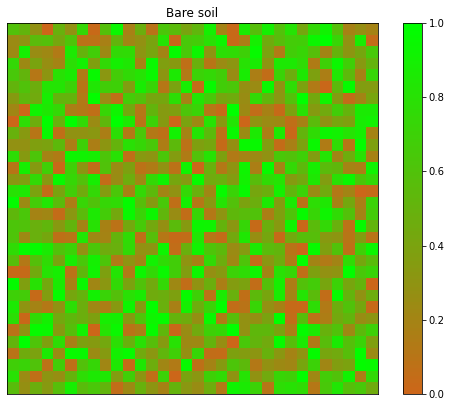

In [27]:
row, col = 2, 2
fig = plt.figure(figsize=(20, 15))
# LV stratum raster
ax2 = fig.add_subplot(row, col, 2)
color_grad = [(0.8, 0.4, 0.1), (0, 1, 0)]  # first color is brown, last is green
cm = clr.LinearSegmentedColormap.from_list("Custom", color_grad, N=100)
ax2.imshow(image_soil, cmap=cm, vmin=0, vmax=1)
ax2.set_title("Bare soil")
ax2.tick_params(
    axis="both",  # changes apply to both axis
    which="both",  # both major and minor ticks are affected
    bottom=False,  # ticks along the bottom edge are off
    top=False,  # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False,
)  # labels along the bottom edge are off
ax2.set_yticklabels([])
ax2.set_xticklabels([])
PCM=ax2.get_children()[9]
plt.colorbar(PCM, ax=ax2)

In [25]:
ax2.get_children()

 Text(0.5, 1.0, 'Bare soil'),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [5]:
# We import functions from github repository
import sys
sys.path.append("..")
from config import args
from model.model import PointNet
from utils.point_cloud_classifier import PointCloudClassifier
from utils.useful_functions import *
from data_loader.loader import *
from utils.open_las import *
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *


In [2]:
# We import functions from github repository
import sys
sys.path.append("..")

from config import args
from model.model import PointNet
from utils.point_cloud_classifier import PointCloudClassifier
from utils.useful_functions import *
from data_loader.loader import *
from utils.open_las import open_las, open_metadata_dataframe
from model.loss_functions import *
from model.accuracy import *
from em_gamma.get_gamma_parameters_em import *

print("Everything is imported")

usage: ipykernel_launcher [-h] [--mode MODE] [--path PATH]
                          [--dataset_folder_path DATASET_FOLDER_PATH]
                          [--las_files_folder_path LAS_FILES_FOLDER_PATH]
                          [--gt_file_path GT_FILE_PATH] [--cuda CUDA]
                          [--folds FOLDS]
                          [--coln_mapper_dict COLN_MAPPER_DICT]
                          [--create_final_images_bool CREATE_FINAL_IMAGES_BOOL]
                          [--results_path RESULTS_PATH]
                          [--stats_path STATS_PATH] [--stats_file STATS_FILE]
                          [--n_class N_CLASS] [--input_feats INPUT_FEATS]
                          [--subsample_size SUBSAMPLE_SIZE]
                          [--diam_pix DIAM_PIX] [--m M]
                          [--norm_ground NORM_GROUND] [--ent ENT] [--e E]
                          [--adm ADM] [--nb_stratum NB_STRATUM]
                          [--ECM_ite_max ECM_ITE_MAX]
                         

TypeError: object of type 'NoneType' has no len()

In [3]:
# Create the result folder
create_new_experiment_folder(args)  # new paths are added to args
# Load groun truth csv file
# Name, 'COUV_BASSE', 'COUV_SOL', 'COUV_INTER', 'COUV_HAUTE', 'ADM'
df_gt, placettes_names = open_metadata_dataframe(args)
print(df_gt.head())
# Load Las files for placettes
all_points, dataset, mean_dataset = open_las(args.dataset_folder_path)
print("Our dataset contains " + str(len(dataset)) + " plots." )

14:44:32
Results folder:  /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/2021-05-26_16h44m32s/
   COUV_BASSE  COUV_SOL  COUV_INTER  COUV_RESSO  COUV_HAUTE  NON_ACC_1  \
0          90        10          25          90          10          0   
1          25        75          10          25           0          0   
2         100         0          10         100          10          0   
3         100         0           0         100           0          0   
4          50        50          10          50           0          0   

   NON_ACC_2  NON_ACC1_2  OBS              Name  couv_bas_1  couv_int  ADM  
0          0           0  NaN  2021_POINT_OBS 1        78.6      19.4   90  
1          0           0  NaN  2021_POINT_OBS 2        20.6       7.4   25  
2          0           0  NaN  2021_POINT_OBS 3       100.0      23.0  100  
3          0           0  NaN  2021_POINT_OBS 4        98.3       5.1  100  
4          0         

In [9]:
# Fit a mixture of 2 gamma distribution if not already done

z_all = all_points[:, 2]
args.z_max = np.max(z_all)   # maximum z value for data normalization, obtained from the normalized dataset analysis
args.n_input_feats = len(args.input_feats)  # number of input features
print_stats(args.stats_file, str(args), print_to_console=True)  # save all the args parameters

params = run_or_load_em_analysis(z_all, args)
print_stats(args.stats_file, str(params), print_to_console=True)

Namespace(path='/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage', dataset_folder_path='/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/placettes_dataset_20210526/', gt_file_path='/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/placettes_dataset_20210526/placettes_metadata.csv', cuda=0, folds=5, coln_mapper_dict={'nom': 'Name'}, n_class=4, input_feats='xyzrgbnir', subsample_size=4096, diam_pix=32, m=1, norm_ground=True, adm=False, nb_stratum=3, ECM_ite_max=5, NR_ite_max=10, MLP_1=[32, 32], MLP_2=[64, 128], MLP_3=[64, 32], drop=0.4, soft=True, wd=0.001, lr=0.001, step_size=50, lr_decay=0.1, n_epoch=2, n_epoch_test=1, batch_size=20, results_path='/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/', stats_path='/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/2021-05-26_16h44m32s/', stats_file='/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_co

In [13]:
df_gt[df_gt["Name"].isin(dataset.keys())]

,COUV_BASSE,COUV_SOL,COUV_INTER,COUV_RESSO,COUV_HAUTE,NON_ACC_1,NON_ACC_2,NON_ACC1_2,OBS,Name,couv_bas_1,couv_int,ADM


In [16]:
dataset.keys()

dict_keys(['2021_POINT_OBS101', 'POINT_OBS106', '2021_POINT_OBS28', '2021_POINT_OBS88', 'POINT_OBS101', '2021_POINT_OBS96', 'POINT_OBS23', '2021_POINT_OBS36', '2021_POINT_OBS22', 'POINT_OBS24', '2021_POINT_OBS9', '2021_POINT_OBS40', '2021_POINT_OBS105', '2021_POINT_OBS64', 'Releve_Lidar_F15', 'POINT_OBS64', '2021_POINT_OBS53', 'Releve_Lidar_F110', 'POINT_OBS11', '2021_POINT_OBS74', 'Releve_Lidar_F65', '2021_POINT_OBS6', 'POINT_OBS67', 'Releve_Lidar_F99', 'Releve_Lidar_F25', '2021_POINT_OBS3', '2021_POINT_OBS55', '2021_POINT_OBS65', 'POINT_OBS38', '2021_POINT_OBS77', 'Releve_Lidar_F46', 'Releve_Lidar_F68', '2021_POINT_OBS92', '2021_POINT_OBS4', 'POINT_OBS40', 'POINT_OBS58', 'POINT_OBS96', 'POINT_OBS35', '2021_POINT_OBS59', 'POINT_OBS59', '2021_POINT_OBS8', 'Releve_Lidar_F89', 'POINT_OBS30', 'POINT_OBS48', 'POINT_OBS28', '2021_POINT_OBS31', 'Releve_Lidar_F102', '2021_POINT_OBS19', '2021_POINT_OBS67', '2021_POINT_OBS7', 'POINT_OBS_8', 'Releve_Lidar_F75', 'Releve_Lidar_F69', '2021_POINT_OB

In [18]:
df_gt["Name"].loc[0]

'2021_POINT_OBS 1'